In [1]:
#imports
from scipy.spatial import distance_matrix
from random import randrange
import copy
import matplotlib.pyplot as plt
import imageio
import imageio
import random
from time import time
from tqdm import tqdm

In [2]:
#loading datasets 
import numpy as np
kroa={}
krob={}
np_kroa=[]
np_krob=[]
with open('kroa200.txt') as f:
    lines = f.readlines()
    for line in lines[6:-1]:
        x=list(map(int,line.strip().split(' ')))
        #print(x)
        kroa[x[0]]=(x[1],x[2])
        np_kroa.append((x[1],x[2]))
np_kroa=np.array(np_kroa)
with open('krob200.txt') as f:
    lines = f.readlines()
    for line in lines[6:-1]:
        x=list(map(int,line.strip().split(' ')))
        #print(x)
        krob[x[0]]=(x[1],x[2])
        np_krob.append((x[1],x[2]))

np_kroa=np.array(np_kroa)
np_krob=np.array(np_krob)

#calculating distance matrix - https://docs.scipy.org/doc/scipy/reference/generated/scipy.spatial.distance_matrix.html
dista=distance_matrix(np_kroa,np_kroa)
distb=distance_matrix(np_krob,np_krob)

In [3]:
#plotting functions
def plotResult(np_dots, cycles):
    plt.clf()
    plt.plot(dataset[:,0][cycles[0][0]], dataset[:,1][cycles[0][0]], "o", markersize=12)
    plt.plot(dataset[:,0][cycles[1][0]], dataset[:,1][cycles[1][0]], "o", markersize=12)
    plt.plot(dataset[:,0][[*cycles[0],cycles[0][0]]], dataset[:,1][[*cycles[0],cycles[0][0]]], "->")
    plt.plot(dataset[:,0][[*cycles[1],cycles[1][1]]], dataset[:,1][[*cycles[1],cycles[1][1]]], "->")
    
def plotPartResult(np_dots, cycles,i):
    plt.plot(np_dots[:,0][cycles[0][0]], np_dots[:,1][cycles[0][0]], "o", markersize=12)
    plt.plot(np_dots[:,0][cycles[1][0]], np_dots[:,1][cycles[1][0]], "o", markersize=12)
    plt.plot(np_dots[:,0][cycles[0]], np_dots[:,1][cycles[0]], "->")
    plt.plot(np_dots[:,0][cycles[1]], np_dots[:,1][cycles[1]], "->")
    plt.plot(np_dots[:,0], np_dots[:,1], ".")
    plt.savefig(f'plots/{i}.png')
    plt.show()    
def calcDistance(currentCycle, dist):
    distance = 0
    for x,y in zip(currentCycle, [*currentCycle[1:], currentCycle[0]]):
        distance += dist[x][y]
    return distance 

In [4]:
# 3rd variable - Generate neighbour solution
#changes edges internally
def change_edges(cycles, edge1, edge2, internally=False): # dummy internally
    cI= 0 if len(np.where(cycles[0] == edge1)[0])!=0 else 1 
#     print(cycles[cI])
    inA=np.where(cycles[cI] == edge1)[0][0]
    inB=np.where(cycles[cI] == edge2)[0][0]
    inA += 1
    inB += 1
    cycle = cycles[cI]
    cycle[inA: inB] = np.flip(cycle[inA: inB])
    return cycles

In [5]:
#changes vertex internally or externaly between cycles
def change_vertices(cycles, a, b, internally=True):
    if internally:
#         print(len(np.where(cycles[0] == a)))
#         print(np.where(cycles[0] == a))
        cI= 0 if len(np.where(cycles[0] == a)[0])!=0 else 1 
        inA=np.where(cycles[cI] == a)[0][0]
        inB=np.where(cycles[cI] == b)[0][0]
        tmp=cycles[cI][inA]
        cycles[cI][inA]=b
        cycles[cI][inB]=tmp
        #print(cycles[0][inB], cycles[0][inA])
    else:
        cI= 0 if len(np.where(cycles[0] == a)[0])!=0 else 1 
        cI2 = 1-cI
        inA=np.where(cycles[cI] == a)[0][0]
        inB=np.where(cycles[cI2] == b)[0][0]
        tmp=cycles[cI][inA]
        cycles[cI][inA]=b
        cycles[cI2][inB]=tmp
        #pass
    #print(cycles)
    return cycles
    #if aIndex in cycles[0]
    #raise NotImplementedError

In [6]:
# 1st variable - Start cycle - with random assignments
def start_cycle_random():
    cycles={}
    cycles[0]=np.random.choice(200,100,replace=False)
    cycles[1]=np.array([i for i in np.arange(0,200,1) if i not in cycles[0]])
    np.random.shuffle(cycles[1])
    return cycles

In [7]:
# 1st variable - Start cycle - with nearest neighbour method
def start_cycle_heuristic(dataset_choice):
    results=[]
    min_result=np.inf
    max_result=0
    if dataset_choice=="kroa":
        dataset=np_kroa
        dic=kroa
        dist=copy.deepcopy(dista)
        dist_stable=copy.deepcopy(dista)
    else:
        dataset=np_krob
        dic=krob
        dist=copy.deepcopy(distb)
        dist_stable=copy.deepcopy(distb)


    #zmiana dystansu przekątnej na nieskonczonosc
    np.fill_diagonal(dist, np.inf)

    cycles={}
    cycles[0]=[randrange(200)]
    cycles[1]=[(np.argsort(dist[cycles[0][0]])[-2])]

    for b in range(2):
        dist[:,int(cycles[b][0])]=np.inf

    chosenCycle=1
    for i in range(0,198):
        chosenCycle = int((chosenCycle + 1)%2)
        candidates=[]
        for z,index in enumerate(cycles[chosenCycle]):
            candidates.append((np.argmin(dist[index]),np.min(dist[index]),z))
        candidates=np.array(candidates)
        x=np.argmin(candidates[:,1])
        cycles[chosenCycle]=np.insert(cycles[chosenCycle],int(candidates[x,2]),int(candidates[x,0]))
        dist[:,int(candidates[x,0])]=np.inf
    
    #print(f"cycle[0]: {calcDistance(cycles[0], dist_stable)}")
    #print(f"cycle[1]: {calcDistance(cycles[1], dist_stable)}")
    
    #SAVING RESULTS 
    results.append(calcDistance(cycles[0],dist_stable)+calcDistance(cycles[1],dist_stable))
    if results[-1]>max_result:
        max_result=results[-1]
    if results[-1]<min_result:
        min_result=results[-1]
#         plt.clf()
#         plt.plot(dataset[:,0][cycles[0][0]], dataset[:,1][cycles[0][0]], "o", markersize=12)
#         plt.plot(dataset[:,0][cycles[1][0]], dataset[:,1][cycles[1][0]], "o", markersize=12)
#         plt.plot(dataset[:,0][cycles[0]], dataset[:,1][cycles[0]], "->")
#         plt.plot(dataset[:,0][cycles[1]], dataset[:,1][cycles[1]], "->")
#         plt.savefig(f'best_NN_{dataset_choice}.png')
    return cycles

In [8]:
# 2nd variable - Find more optimal solution
# switch parameter defines how u find neighbour solutions (is it change_vertices or change_edges func)
def greedy_search(dist, np_dots, init_random = False, switch="change_edges", cycles=None):
    #specify cycles initialization.
    if cycles is None:
        if init_random:
            cycles = start_cycle_random()
        else:
            cycles = start_cycle_heuristic()
    #print(cycles)
    
    if switch == "change_vertices":
        internal_change = change_vertices
    elif switch == "change_edges":
        internal_change = change_edges
    else:
        print(f"Unknow mode {switch}. Select change_vertices or change_edges")
        return
    
    
    
    bestDistance = 0
    #print(cycles[0])
    bestDistance += calcDistance(cycles[0], dist) 
    bestDistance += calcDistance(cycles[1], dist) 
    #print(f"Initial distance: {bestDistance}")
    
    #plotPartResult(np_dots, cycles)
    
    
    done = False
    while not done:
        done = True
        #-------------calculating possible moves
        possible_moves = []
        
        mesh = np.array(np.meshgrid(cycles[0], cycles[1]))
        combinations = mesh.T.reshape(-1, 2)
        for x in combinations:
            possible_moves.append(["external", x])

        mesh = np.array(np.meshgrid(cycles[0], cycles[0]))
        mesh = np.concatenate((mesh,np.array(np.meshgrid(cycles[1], cycles[1]))),axis=0)
        combinations = mesh.T.reshape(-1, 2)
        for x in combinations:
            possible_moves.append(["internal", x])
        
        possible_moves = np.array(possible_moves)
        i = np.random.choice(range(len(possible_moves)),len(possible_moves),replace=False)
        possible_moves = possible_moves[i]
        

        for move, edges in possible_moves:
#             print(move, edges)
            cyclesCopy = copy.deepcopy(cycles)
            edge1 = edges[0]
            edge2 = edges[1]
            
#             print(edge1, edge2)
            if move == "internal":
                cyclesCopy = internal_change(cyclesCopy, edge1, edge2, internally=True)
            else:
                cyclesCopy = change_vertices(cyclesCopy, edge1, edge2, False)
#             plotPartResult(np_dots, cycles)
            currentDistance = 0
            currentDistance += calcDistance(cyclesCopy[0], dist)
            currentDistance += calcDistance(cyclesCopy[1], dist)
            if currentDistance < bestDistance:
                #print(f"New best distance: {currentDistance}, changed {edge1} with {edge2} on {move}")
                cycles = cyclesCopy
                bestDistance = currentDistance
                done = False
                break
    
#     plotPartResult(np_dots, cycles)
#     plt.show()
    return cycles, bestDistance
    

## Genetic

In [9]:
# #TestPopulation
# testpopulation=[]
# dataset=np_kroa
# dist=copy.deepcopy(dista)
# for i in tqdm(range(0,20)):
#         testpopulation.append(greedy_search(dist, dataset, init_random = True, switch="change_edges"))

In [10]:
# 1st variable - Start cycle - with nearest neighbour method
def rebuild_cycle_heuristic(cycles,dataset_choice):
    results=[]
    min_result=np.inf
    max_result=0
    if dataset_choice=="kroa":
        dataset=np_kroa
        dic=kroa
        dist=copy.deepcopy(dista)
        dist_stable=copy.deepcopy(dista)
    else:
        dataset=np_krob
        dic=krob
        dist=copy.deepcopy(distb)
        dist_stable=copy.deepcopy(distb)


    #zmiana dystansu przekątnej na nieskonczonosc
    np.fill_diagonal(dist, np.inf)

#     cycles={}
#     cycles[0]=[randrange(100)]
#     cycles[1]=[(np.argsort(dist[cycles[0][0]])[-2])]

    for b in range(2):
        for d in range(len(cycles[b])):
            dist[:,int(cycles[b][d])]=np.inf

    chosenCycle=1
    #taken=len(cycles[0])+len(cycles[1])
    while len(cycles[0])+len(cycles[1])<200:
        chosenCycle = int((chosenCycle + 1)%2)
        if(len(cycles[chosenCycle])<100):
            candidates=[]
            for z,index in enumerate(cycles[chosenCycle]):
                candidates.append((np.argmin(dist[index]),np.min(dist[index]),z))
            candidates=np.array(candidates)
            x=np.argmin(candidates[:,1])
            cycles[chosenCycle]=np.insert(cycles[chosenCycle],int(candidates[x,2]),int(candidates[x,0]))
            dist[:,int(candidates[x,0])]=np.inf

#     #SAVING RESULTS 
#     results.append(calcDistance(cycles[0],dist_stable)+calcDistance(cycles[1],dist_stable))
#     if results[-1]>max_result:
#         max_result=results[-1]
#     if results[-1]<min_result:
#         min_result=results[-1]

    return cycles

In [11]:
def evo(dataset_choice, durationSec=10,do_ls=False): 
    if dataset_choice=="kroa":
        dataset=np_kroa
        dic=kroa
        dist=copy.deepcopy(dista)
        dist_stable=copy.deepcopy(dista)
    else:
        dataset=np_krob
        dic=krob
        dist=copy.deepcopy(distb)
        dist_stable=copy.deepcopy(distb)    

    bestBestDist = np.inf
    startTime = time()
    
    population=[]
    
    for i in range(0,20):
        #Population zawiera dwuelementowe elementy (cycles,bestDist)
        population.append(greedy_search(dist, dataset, init_random = True, switch="change_edges"))
    #population=copy.deepcopy(testpopulation)
    
    notnow=0
    while (time() - startTime < durationSec):
        div=0
        chosen=np.random.choice(len(population),2,replace=False)
        parent1=population[chosen[0]][0]
        keys1, values1 = zip(*parent1.items())
        values1=np.array(values1)
        values1=values1.ravel()
        parent2=population[chosen[1]][0]
        #print(values1)
        keys2, values2 = zip(*parent2.items())
        values2=np.array(values2)
        values2=values2.ravel()
        child=copy.deepcopy(parent1)
        #print(child)
        population_mix=1
        for i_in,i in enumerate(values1):
            #print(i)
            for j_in,j in enumerate(values2):
                if i==j:
                    #print("AAA")
                    #print()
#                     print("==")
#                     print(values1[(i_in-1+len(values1))%len(values1)],values1[i_in],values1[(i_in+1+len(values1))%len(values1)])
#                     print(values2[(i_in-1+len(values2))%len(values2)],values2[i_in],values2[(i_in+1+len(values2))%len(values2)])
#                     print("==")
                    if not values1[(i_in-1+len(values1))%len(values1)]==values2[(j_in-1+len(values2)%len(values2))] and not \
                    values1[(i_in+1+len(values1))%len(values1)]==values2[(j_in+1+len(values2))%len(values2)]==0:
                        div+=1
                        #print("AAAA")
                        if values1[i_in] in child[0]:
                            child[0]=child[0][child[0] != values1[i_in]]#child[0][.remove(values1[i_in])
                        else:
                            child[1]=child[1][child[1] != values1[i_in]]
                        population_mix=0
        if population_mix:
            #print("AAAAAAAAAAAAAAAAA")
            notnow+=1
            if notnow%25==0:
                #print("BBBBBBBBBBBBBBBBBBBB")
                population[np.argmax(np_population[:,1])]=greedy_search(dist, dataset, init_random = True, switch="change_edges")
        new_cycles=rebuild_cycle_heuristic(child,dataset_choice)
        #print(len(new_cycles[0]),len(new_cycles[1]))
        if do_ls:
            new_cycles=greedy_search(dist,dataset,cycles=new_cycles)[0]
            #print(new_cycles)

        #print(new_cycles)
        np_population=np.array(population)
        childDist=calcDistance(new_cycles[0],dist)+calcDistance(new_cycles[1],dist)
        #print(childDist,np.max(np_population[:,1]))
        if childDist<np.max(np_population[:,1]) and childDist not in np_population[:,1]:
#             print(population)
#             print("AA")
            population[np.argmax(np_population[:,1])]=(child,childDist)
#             print(population)
        #print(np.min(np.array(population)[:,1]))
        #print(np.mean(np.array(population)[:,1]))
        #return new_cycles
                       #USUN Z CHILD TEN WIERZCHOŁEK
           #wylosuj 2 rozwiazania z population
           #Ewoluuj - wywal wszystkie krawedzie ktore sa w 1 a nie ma w 2 (wierzcholki bez krawedzi usuwamy)
           #Usun tylko wierzcholki do ktorych nie dochodza zadne krawedzie
           #Odbuduj zgodnie z metodą z ILS2
           #Jezeli nie ma takiego bestDist w population[:,1] i jest krótszy od najdluzszego to zamien go z nim miejscami
           
    
    #print(population)
    return np.array(population)[np.argmin(np.array(population)[:,1])]#,np.min(np.array(population)[:,1]
    #return najmniejszy dist z population i te cykle

100%|██████████| 6/6 [4:11:50<00:00, 2518.42s/it]  


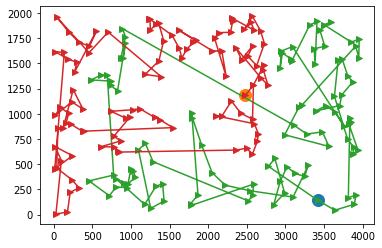

100%|██████████| 6/6 [4:10:00<00:00, 2500.04s/it]  


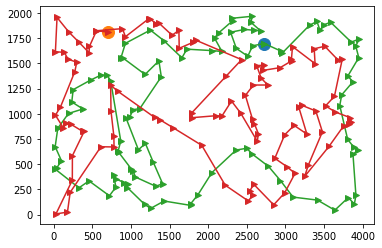

100%|██████████| 6/6 [4:12:06<00:00, 2521.01s/it]  


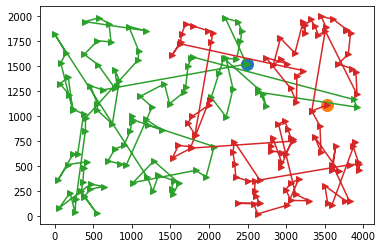

100%|██████████| 6/6 [4:10:00<00:00, 2500.03s/it]  


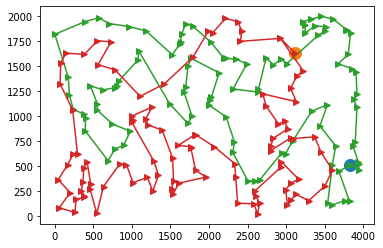

In [12]:
for dataset_choice in ["kroa","krob"]:
    if dataset_choice=="kroa":
        dataset=np_kroa
        dic=kroa
        dist=copy.deepcopy(dista)
        dist_stable=copy.deepcopy(dista)
    else:
        dataset=np_krob
        dic=krob
        dist=copy.deepcopy(distb)
        dist_stable=copy.deepcopy(distb)    
    for DOLS in [True,False]:
        cyclesTable = []
        distanceTable = []
        for i in tqdm(range(6)):
            cycles,bestDist=evo(dataset_choice=dataset_choice, durationSec=2500,do_ls=DOLS)
            cyclesTable.append(cycles)
            distanceTable.append(bestDist)
        cycles = cyclesTable[np.argmin(distanceTable)]
        plt.clf()
        plt.plot(dataset[:,0][cycles[0][0]], dataset[:,1][cycles[0][0]], "o", markersize=12)
        plt.plot(dataset[:,0][cycles[1][0]], dataset[:,1][cycles[1][0]], "o", markersize=12)                
        plt.plot(dataset[:,0][[*cycles[0],cycles[0][0]]], dataset[:,1][[*cycles[0],cycles[0][0]]], "->")
        plt.plot(dataset[:,0][[*cycles[1],cycles[1][1]]], dataset[:,1][[*cycles[1],cycles[1][1]]], "->")
        plt.savefig(f"Genetic_LS-{DOLS}_{dataset_choice}.png")
        plt.show()
        with open(f"Genetic_LS-{DOLS}_{dataset_choice}.txt", "w") as f:
            f.write(f"min:{np.min(distanceTable)}, max:{np.max(distanceTable)}, mean:{np.mean(distanceTable)}")

In [115]:
cycles,bestDist=evo(dataset_choice="kroa", durationSec=30, do_ls=True)
plotResult(dataset,cycles)

100 100


/home/mikolaj/.local/lib/python3.6/site-packages/ipykernel_launcher.py:48: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray


KeyboardInterrupt: 

In [14]:
#print(testpopulation)
keys1, values1 = zip(*testpopulation[0][0].items())
values1=np.array(values1)
values1.ravel()

array([ 18,  65, 178,  36,   8,  81,  77,  25, 135,  60, 183,  28, 109,
        17,  48, 189, 148,  98,  13, 105,  92, 162, 146,  11, 120, 173,
       158, 110,  14,  78, 159,  66, 119, 185, 111, 154,  16,  24, 142,
        89,  33, 102,  97, 199, 147,  87, 113, 128, 145,   7,  74,  53,
       150, 186,   5, 108, 106, 156,  46,  30,  64,  79,  76, 157, 192,
       127, 166,  29,  67, 168,  22, 172, 149, 138,  70, 177, 195,  85,
        75,  69, 101,  20, 153,  88,  40,  58,  72,   2,  68, 188, 130,
       179, 155,  99,  32,  80,  96,  44, 196,  91, 140, 170,  27,  37,
        55, 151,   4, 104,  42, 136, 132, 175, 112, 194, 181,  93,  94,
        90, 143, 139, 163,  34,   1, 180, 124, 160,  59, 100,   3, 191,
       107, 141,  73,  56,  35, 174,   9, 118, 103, 164, 165,  95, 125,
        86,  51,  10,  83,  47, 152,  43,  62, 187, 115, 169, 121, 193,
        50,  15, 117, 123, 137, 198,   6,  31,  23, 171,  45,  39, 131,
        52, 116, 114,   0,  84, 144, 190,  26, 197, 122,  12, 17

In [124]:
# print(testpopulation)

In [18]:
print(np.array(testpopulation)[:,1],np.array(testpopulation)[:,1])

[39005.68805544493 37050.01013759442 39041.59139933274 36471.41805764832
 39740.48568086652 39533.66306542681 38206.83638510897 39174.416320511526
 38516.630715735264 39340.70273164852 39955.299273758734
 37902.135304559895 38505.89493511321 39145.00878723907 38159.378775386445
 39254.00071138321 38594.27041821007 38717.00029133816 37504.05965075742
 40227.42476246583] [39005.68805544493 37050.01013759442 39041.59139933274 36471.41805764832
 39740.48568086652 39533.66306542681 38206.83638510897 39174.416320511526
 38516.630715735264 39340.70273164852 39955.299273758734
 37902.135304559895 38505.89493511321 39145.00878723907 38159.378775386445
 39254.00071138321 38594.27041821007 38717.00029133816 37504.05965075742
 40227.42476246583]


In [21]:
np_population=np.array(testpopulation)

In [23]:
childDist=36671.3863720199 

In [25]:
childDist<np.max(np_population[:,1]) and childDist not in np_population[:,1]

True

In [60]:
start_cycle_heuristic()

{0: array([  6, 198,  25, 171,  45, 120, 173, 158,  23,  31, 135,  51,  86,
        125,  95, 103, 164, 165,  10,  47,  83, 169, 121, 115,  65, 152,
         43, 187, 193,  50,  62, 178,  15, 117, 192,  42, 136, 104,  24,
         89,  33,  57, 140, 170, 199, 147,   4,  85, 138,  88,  72,   2,
         58,  40, 166, 127,  59, 100,   3, 162,  92, 105,  18, 155, 196,
         96,  80,  44,  32,  99,  73,  56, 179, 130, 188,  68, 141, 107,
        191,  13,  35, 174,   9, 118,  91,  98, 148, 189,  48,  17, 109,
         28, 183,  36, 123,  81,  77,   8, 137,  60]),
 1: array([ 94,  75, 101,  69, 143,  29,  67, 157,  76,  79,  66,  30, 134,
         19,  64, 176,  26, 144, 116, 114, 110,  52,   0,  11, 146,  39,
        131,  84, 190, 197, 122,  14,  12,  78, 159, 161,  63,  54,  41,
        185, 126, 111, 119,  46, 156, 154, 133,   7,  21, 182,  74, 106,
        108,  53,   5, 186, 150, 160, 124, 180,   1,  34, 168, 153,  20,
        139, 163,  22,  49,  38, 128, 145,  16, 142, 102, 113, 